<a href="https://colab.research.google.com/github/elisim/informer-blog-hf/blob/main/Multivariate_Time_Series_Forecasting_with_Informer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multivariate Probabilistic Time Series Forecasting with Informer

## Table of contents
Todo

## Introduction

Few months ago we introduced the [Time Series Transformer](https://huggingface.co/blog/time-series-transformers), which is the vanilla Transformer ([Vaswani et al., 2017](https://arxiv.org/abs/1706.03762)), and showed an example for the **univariate** probabilistic forecasting task (i.e. predicting each time series' 1-d distribution individually). In this post we introduce the _Informer_ model ([Zhou, Haoyi, et al., 2021](https://arxiv.org/abs/2012.07436)), AAAI21 best paper which is now available in 🤗 Transformers. We will show how to use Informer for the **multivariate** probabilistic forecasting task, i.e., predicting the distribution of a future **vector** of time-series target values.

##  Multivariate Probabilistic Time Series Forecasting

As far as the modeling aspect of probablistic forecasting is concerned the Transfomer/Informer will require no change when dealing with multivariate time series. In both the univariate and multivariate setting the model will recieve a sequence of vectors and thus the only change is on the output or emission side.

Modeling the full joint conditional distribution of a high dimensional data can get computationally expensive and thus methods resort to some approximation of the distribution, the easiest being to model the data as independent distribution from the same family, or some low-rank approximation to the full covariance, etc. Here we will just resort to the independent (or diagonal) emissions which is supported for the families of distributions we have implemented. 

## Informer - Under The Hood

Todo: Informer picture

Based on the vanilla Transformer ([Vaswani et al., 2017](https://arxiv.org/abs/1706.03762)), Informer employs two major improvements. To understand these improvments, let's recall the vanilla Transformer  drawbacks:

1. Quadratic computation of canonical self-attention: The vanilla Transformer has computational complexity of $O(T^2 D)$ where $T$ is the time series length and $D$ is the dimension of the hidden states. For long sequence time-series forecasting (also known as the _LSTF problem_), this might be really computationally expensive. To solve this problem, Informer employs a new self-attention mechanism called ProbSparse, which has $O(T \log T)$ time and space complexity.

2. Memory bottleneck when stacking layers: When stacking $N$ encoder/decoder layers, the vanilla Transformer has  memory usage of $O(N T^2)$, which limits the model's capacity for long sequences. Informer uses a distilling operation, for reducing the input size between layers into its half slice. By doing so, it reduces the whole memory usage to be $O(T  \log T)$.

As you can see, the motivation for the Informer is similar to Longformer (xxx), Sparse Transformer and other NLP papers (xxx) for reducing the quadratic complexity of the self-attention **when the input sequence is long**. Now, let's dive into ProbSparse attention and the Distilling operation with code examples. 

### ProbSparse Attention (Complete)

The canonical self-attention scores form a long-tail distribution, where the "active" queries lie in the "head" scores and "lazy" queries lie in the "tail" area. We designed the ProbSparse Attention to select the "active" queries rather than the "lazy" queries.

ProbSparse is based on the idea that the attention weights are composed from few dot-product pairs that contribute to the major attention. Our goal is to find those pairs, and create a reduced Query matrix which will be used for calculating the attention weights
In more details, recall the canonical self attention:

TODO canonical self attention formula 

We want to find the dot-product pairs which contribute to QK multiplication. How? .

We want to find a Query matrix Q_reduce such that Q_reduce * K will contain only the paris that contribute to the major attention. But how to find this Q_reduce? 

1. few dot-product contribute - motivation
2. the queries in dot-product who do not contribute, forms a uniform distribution. We want to select queries which don't
form a uniform distribution
3. Define sparsity mesurse for select the best quries 

Code:

1. create the U_part from K 
2. find u for top-u queries 
3. compute Q_K_sample 
4. slice top_u from it

#### Query Sparsity Measurement
The dominant <q,k> pairs encourage the corresponding query’s attention probability distribution away from the uniform distribution. 


### Distilling (Complete)
conv layers between encoder layers

***************

***************

The _Informer_ model in now available in the 🤗 Transformers library, which simply called `InformerModel`. In the sections below, we will show how to train this model on a custom multivariate time-series dataset.


## Set-up Environment

First, let's install the necessary libraries: 🤗 Transformers, 🤗 Datasets, 🤗 Evaluate,  🤗 Accelerate and [GluonTS](https://github.com/awslabs/gluonts).

As we will show, GluonTS will be used for transforming the data to create features as well as for creating appropriate training, validation and test batches.

In [1]:
# !pip install -q transformers

In [2]:
# !pip install -q datasets

In [3]:
# !pip install -q evaluate

In [4]:
# !pip install -q accelerate

In [5]:
# !pip install -q gluonts ujson

### Todo: ask Kashif if we need this (it's in the colab version of the https://huggingface.co/blog/time-series-transformers but not in the blog version)
We also quickly upload some telemetry - this tells us which examples and software versions are getting used so we know where to prioritize our maintenance efforts. We don't collect (or care about) any personally identifiable information, but if you'd prefer not to be counted, feel free to skip this step or delete this cell entirely.

In [6]:
# from transformers.utils import send_example_telemetry

# send_example_telemetry("time_series_transformers_notebook", framework="pytorch")

## Load Dataset

In this blog post, we'll use the `traffic_hourly` dataset, which is available on the [Hugging Face Hub](https://huggingface.co/datasets/monash_tsf). This dataset contains the San Francisco Traffic dataset used by [Lai et al. (2017)](https://arxiv.org/abs/1703.07015). It contains 862 hourly time series showing the road occupancy rates on the San Francisco Bay area freeways from 2015 to 2016.


This dataset is part of the [Monash Time Series Forecasting](https://forecastingdata.org/) repository, a collection of  time series datasets from a number of domains. It can be viewed as the [GLUE benchmark](https://gluebenchmark.com/) of time series forecasting.

In [16]:
from datasets import load_dataset

dataset = load_dataset("monash_tsf", "traffic_hourly")

  0%|          | 0/3 [00:00<?, ?it/s]

As can be seen, the dataset contains 3 splits: train, validation and test.

In [17]:
dataset

DatasetDict({
    train: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 862
    })
    test: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 862
    })
    validation: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 862
    })
})

Each example contains a few keys, of which `start` and `target` are the most important ones. Let us have a look at the first time series in the dataset:

In [18]:
train_example = dataset["train"][0]
train_example.keys()

dict_keys(['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'])

The `start` simply indicates the start of the time series (as a datetime), and the `target` contains the actual values of the time series.

The `start` will be useful to add time related features to the time series values, as extra input to the model (such as "month of year"). Since we know the frequency of the data is `hourly`, we know for instance that the second value has the timestamp `2015-01-01 01:00:01`, `2015-01-01 02:00:01`, etc.

In [19]:
print(train_example["start"])
print(len(train_example["target"]))

2015-01-01 00:00:01
17448


The validation set contains the same data as the training set, just for a `prediction_length` longer amount of time. This allows us to validate the model's predictions against the ground truth.

The test set is again one `prediction_length` longer data compared to the validation set (or some multiple of  `prediction_length` longer data compared to the training set for testing on multiple rolling windows).

In [20]:
validation_example = dataset["validation"][0]
validation_example.keys()

dict_keys(['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'])

The initial values are exactly the same as the corresponding training example. However, this example has `prediction_length=48` additional values compared to the training example. Let us verify it.

In [21]:
freq = "1H"
prediction_length = 48

assert len(train_example["target"]) + prediction_length == len(dataset["validation"][0]["target"])

Let's visualize this:

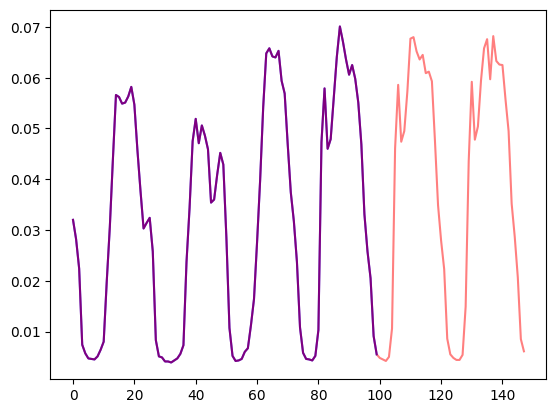

In [68]:
import matplotlib.pyplot as plt

figure, axes = plt.subplots()
axes.plot(train_example["target"][-100:], color="blue") 
axes.plot(validation_example["target"][-100 - prediction_length:], color="red", alpha=0.5)

plt.show()

Let's split up the data:

In [22]:
train_dataset = dataset["train"]
test_dataset = dataset["test"]

## Update `start` to `pd.Period`

The first thing we'll do is convert the `start` feature of each time series to a pandas `Period` index using the data's `freq`:

In [23]:
from functools import lru_cache

import pandas as pd
import numpy as np

@lru_cache(10_000)
def convert_to_pandas_period(date, freq):
    return pd.Period(date, freq)

def transform_start_field(batch, freq):
    batch["start"] = [convert_to_pandas_period(date, freq) for date in batch["start"]]
    return batch

We now use `datasets`' [`set_transform`](https://huggingface.co/docs/datasets/v2.7.0/en/package_reference/main_classes#datasets.Dataset.set_transform) functionality to do this on-the-fly in place:

In [24]:
from functools import partial

train_dataset.set_transform(partial(transform_start_field, freq=freq))
test_dataset.set_transform(partial(transform_start_field, freq=freq))

Now, let's convert the dataset into multivariate time series using `MultivariateGrouper` from GluonTS:

In [25]:
from gluonts.dataset.multivariate_grouper import MultivariateGrouper

num_of_variates = 862

train_grouper = MultivariateGrouper(max_target_dim=num_of_variates)
test_grouper = MultivariateGrouper(max_target_dim=num_of_variates, num_test_dates=1)

mv_train_dataset = train_grouper(train_dataset)
mv_test_dataset = test_grouper(test_dataset)

Note that now the target is 2 dimensional, where the first dim is the number of variates (number of time-series) and the second is the time-series values: 

In [26]:
mv_train_example = mv_train_dataset[0]
print("mv_train_example[\"target\"].shape =", mv_train_example["target"].shape)

mv_train_example["target"].shape = (862, 17448)


## Define the model


Next, let's instantiate a model. The model will be trained from scratch, hence we won't use the `from_pretrained` method here, but rather randomly initialize the model from a [`config`](https://huggingface.co/docs/transformers/model_doc/time_series_transformer#transformers.TimeSeriesTransformerConfig).

TODO: Change to Informer config

We specify a couple of additional parameters to the model:
- `prediction_length` (in our case, `48` hours): this is the horizon that the decoder of the Transformer will learn to predict for;
- `context_length`: the model will set the `context_length` (input of the encoder) equal to the `prediction_length`, if no `context_length` is specified;
- `lags` for a given frequency: these specify how much we "look back", to be added as additional features. e.g. for a `Daily` frequency we might consider a look back of `[1, 2, 7, 30, ...]` or in other words look back 1, 2, ... days while for `Minute` data we might consider `[1, 30, 60, 60*24, ...]` etc.;
- the number of time features: in our case, this will be `2` as we'll add `MonthOfYear` and `Age` features;
- the number of static categorical features: in our case, this will be just `1` as we'll add a single "time series ID" feature;
- the cardinality: the number of values of each static categorical feature, as a list which for our case will be `[862]` as we have 862 different time series
- the embedding dimension: the embedding dimension for each static categorical feature, as a list, for example `[3]` meaning the model will learn an embedding vector of size `3` for each of the `862` time series.


Let's use the default lags provided by GluonTS for the given frequency ("hourly"):

In [29]:
from gluonts.time_feature import get_lags_for_frequency

lags_sequence = get_lags_for_frequency(freq)
print(lags_sequence)

[1, 2, 3, 4, 5, 6, 7, 23, 24, 25, 47, 48, 49, 71, 72, 73, 95, 96, 97, 119, 120, 121, 143, 144, 145, 167, 168, 169, 335, 336, 337, 503, 504, 505, 671, 672, 673, 719, 720, 721]


This means that we'll look back up to 721 hours (~30 days) for each time step, as additional features.

Let's also check the default time features which GluonTS provides us:

In [27]:
from gluonts.time_feature import time_features_from_frequency_str

time_features = time_features_from_frequency_str(freq)
print(time_features)

[<function hour_of_day at 0x7fe03011b7f0>, <function day_of_week at 0x7fe03011b910>, <function day_of_month at 0x7fe03011ba30>, <function day_of_year at 0x7fe03011bb50>]


In this case, there are four additional features, namely "hour of day", "day of week", "day of month" and "day of year". This means that for each time step, we'll add these features as a scalar values. For example, consider the timestamp `2015-01-01 01:00:01`. The four additional features will be:

In [22]:
from pandas.core.arrays.period import period_array

timestamp = pd.Period("2015-01-01 01:00:01", freq=freq)
timestamp_as_index = pd.PeriodIndex(data=period_array([timestamp]))
additional_features = [(time_feature.__name__, time_feature(timestamp_as_index)) for time_feature in time_features]
print(dict(additional_features))

{'hour_of_day': array([-0.45652174]), 'day_of_week': array([0.]), 'day_of_month': array([-0.5]), 'day_of_year': array([-0.5])}


Note that hours and days are encoded as values between [-0.5, 0.5] from GluonTS. For more information about `time_features`, please see [this](https://github.com/awslabs/gluonts/blob/dev/src/gluonts/time_feature/_base.py).
We now have everything to define the model:

In [30]:
from transformers import InformerConfig, InformerForPrediction

config = InformerConfig(
    prediction_length=prediction_length,
    # in the multivariate setting, input_size is the number of variates in the time series per time step
    input_size=num_of_variates,
    # context length:
    context_length=prediction_length * 2,
    # lags coming from helper given the freq:
    lags_sequence=[1, 24, 24*7],
    # we'll add 5 time features ("month of year" and "age", see further):
    num_time_features=len(time_features) + 1,

    # transformer params:
    encoder_layers=4,
    decoder_layers=4,
    d_model=1024,
)

model = InformerForPrediction(config)

Note that, similar to other models in the 🤗 Transformers library, [`TimeSeriesTransformerModel`](https://huggingface.co/docs/transformers/model_doc/time_series_transformer#transformers.TimeSeriesTransformerModel) corresponds to the encoder-decoder Transformer without any head on top, and [`TimeSeriesTransformerForPrediction`](https://huggingface.co/docs/transformers/model_doc/time_series_transformer#transformers.TimeSeriesTransformerForPrediction) corresponds to `TimeSeriesTransformerModel` with a **distribution head** on top. By default, the model uses a Student-t distribution (but this is configurable):

In [31]:
model.config.distribution_output

'student_t'

This is an important difference with Transformers for NLP, where the head typically consists of a fixed categorical distribution implemented as an `nn.Linear` layer.

## Define Transformations

Next, we define the transformations for the data, in particular for the creation of the time features (based on the dataset or universal ones).

Again, we'll use the GluonTS library for this. We define a `Chain` of transformations (which is a bit comparable to `torchvision.transforms.Compose` for images). It allows us to combine several transformations into a single pipeline.

In [34]:
from gluonts.time_feature import TimeFeature
from gluonts.dataset.field_names import FieldName
from gluonts.transform import (
    AddAgeFeature,
    AddObservedValuesIndicator,
    AddTimeFeatures,
    AsNumpyArray,
    Chain,
    ExpectedNumInstanceSampler,
    InstanceSplitter,
    RemoveFields,
    SelectFields,
    SetField,
    TestSplitSampler,
    Transformation,
    ValidationSplitSampler,
    VstackFeatures,
    RenameFields,
)

The transformations below are annotated with comments, to explain what they do. At a high level, we will iterate over the individual time series of our dataset and add/remove fields or features:

In [35]:
from transformers import PretrainedConfig

def create_transformation(freq: str, config: PretrainedConfig) -> Transformation:
    # create list of fields to remove later
    remove_field_names = []
    if config.num_static_real_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_REAL)
    if config.num_dynamic_real_features == 0:
        remove_field_names.append(FieldName.FEAT_DYNAMIC_REAL)
    ## Eli - added check if num_dynamic_categorical_features and num_static_categorical_features are zero
    if config.num_static_categorical_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_CAT)
#     if config.num_dynamic_categorical_features == 0:
#         remove_field_names.append(FieldName.FEAT_DYNAMIC_CAT)
    
    return Chain(
        # step 1: remove static/dynamic fields if not specified
        [RemoveFields(field_names=remove_field_names)]
        # step 2: convert the data to NumPy (potentially not needed)
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_CAT,
                    expected_ndim=1,
                    dtype=int,
                )
            ]
            if config.num_static_categorical_features > 0
            else []
        )
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_REAL,
                    expected_ndim=1,
                )
            ]
            if config.num_static_real_features > 0
            else []
        )
        + [
            AsNumpyArray(
                field=FieldName.TARGET,
                # we expect an extra dim for the multivariate case:
                expected_ndim=1 if config.input_size == 1 else 2,
            ),
            # step 3: handle the NaN's by filling in the target with zero
            # and return the mask (which is in the observed values)
            # true for observed values, false for nan's
            # the decoder uses this mask (no loss is incurred for unobserved values)
            # see loss_weights inside the xxxForPrediction model
            AddObservedValuesIndicator(
                target_field=FieldName.TARGET,
                output_field=FieldName.OBSERVED_VALUES,
            ),
            # step 4: add temporal features based on freq of the dataset
            # these serve as positional encodings
            AddTimeFeatures(
                start_field=FieldName.START,
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_TIME,
                time_features=time_features_from_frequency_str(freq),
                pred_length=config.prediction_length,
            ),
            # step 5: add another temporal feature (just a single number)
            # tells the model where in the life the value of the time series is
            # sort of running counter
            AddAgeFeature(
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_AGE,
                pred_length=config.prediction_length,
                log_scale=True,
            ),
            # step 6: vertically stack all the temporal features into the key FEAT_TIME
            VstackFeatures(
                output_field=FieldName.FEAT_TIME,
                input_fields=[FieldName.FEAT_TIME, FieldName.FEAT_AGE]
                + (
                    [FieldName.FEAT_DYNAMIC_REAL]
                    if config.num_dynamic_real_features > 0
                    else []
                ),
            ),
            # step 7: rename to match HuggingFace names
            RenameFields(
                mapping={
                    FieldName.FEAT_STATIC_CAT: "static_categorical_features",
                    FieldName.FEAT_STATIC_REAL: "static_real_features",
                    FieldName.FEAT_TIME: "time_features",
                    FieldName.TARGET: "values",
                    FieldName.OBSERVED_VALUES: "observed_mask",
                }
            ),
        ]
    )

## Define `InstanceSplitter`

For training/validation/testing we next create an `InstanceSplitter` which is used to sample windows from the dataset (as, remember, we can't pass the entire history of values to the Transformer due to time- and memory constraints).

The instance splitter samples random `context_length` sized and subsequent `prediction_length` sized windows from the data, and appends a `past_` or `future_` key to any temporal keys for the respective windows. This makes sure that the `values` will be split into `past_values` and subsequent `future_values` keys, which will serve as the encoder and decoder inputs respectively. The same happens for any keys in the `time_series_fields` argument:

In [36]:
from gluonts.transform.sampler import InstanceSampler
from typing import Optional


def create_instance_splitter(
    config: PretrainedConfig,
    mode: str,
    train_sampler: Optional[InstanceSampler] = None,
    validation_sampler: Optional[InstanceSampler] = None,
) -> Transformation:
    assert mode in ["train", "validation", "test"]

    instance_sampler = {
        "train": train_sampler
        or ExpectedNumInstanceSampler(
            num_instances=1.0, min_future=config.prediction_length
        ),
        "validation": validation_sampler
        or ValidationSplitSampler(min_future=config.prediction_length),
        "test": TestSplitSampler(),
    }[mode]

    return InstanceSplitter(
        target_field="values",
        is_pad_field=FieldName.IS_PAD,
        start_field=FieldName.START,
        forecast_start_field=FieldName.FORECAST_START,
        instance_sampler=instance_sampler,
        past_length=config.context_length + max(config.lags_sequence),
        future_length=config.prediction_length,
        time_series_fields=["time_features", "observed_mask"],
    )

## Create PyTorch DataLoaders

Next, it's time to create PyTorch DataLoaders, which allow us to have batches of (input, output) pairs - or in other words (`past_values`, `future_values`).

In [37]:
from gluonts.itertools import Cyclic, IterableSlice, PseudoShuffled
from gluonts.torch.util import IterableDataset
from torch.utils.data import DataLoader

from typing import Iterable


def create_train_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    num_batches_per_epoch: int,
    shuffle_buffer_length: Optional[int] = None,
    **kwargs,
) -> Iterable:
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    TRAINING_INPUT_NAMES = PREDICTION_INPUT_NAMES + [
        "future_values",
        "future_observed_mask",
    ]

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=True)

    # we initialize a Training instance
    instance_splitter = create_instance_splitter(config, "train") + SelectFields(
        TRAINING_INPUT_NAMES
    )

    # the instance splitter will sample a window of
    # context length + lags + prediction length (from the 366 possible transformed time series)
    # randomly from within the target time series and return an iterator.
    training_instances = instance_splitter.apply(
        Cyclic(transformed_data)
        if shuffle_buffer_length is None
        else PseudoShuffled(
            Cyclic(transformed_data),
            shuffle_buffer_length=shuffle_buffer_length,
        )
    )

    # from the training instances iterator we now return a Dataloader which will
    # continue to sample random windows for as long as it is called
    # to return batch_size of the appropriate tensors ready for training!
    return IterableSlice(
        iter(
            DataLoader(
                IterableDataset(training_instances),
                batch_size=batch_size,
                **kwargs,
            )
        ),
        num_batches_per_epoch,
    )

In [38]:
def create_test_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    **kwargs,
):
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=False)

    # we create a Test Instance splitter which will sample the very last
    # context window seen during training only for the encoder.
    instance_sampler = create_instance_splitter(config, "test") + SelectFields(
        PREDICTION_INPUT_NAMES
    )

    # we apply the transformations in test mode
    testing_instances = instance_sampler.apply(transformed_data, is_train=False)

    # This returns a Dataloader which will go over the dataset once.
    return DataLoader(
        IterableDataset(testing_instances), batch_size=batch_size, **kwargs
    )


In [61]:
train_dataloader = create_train_dataloader(
    config=config,
    freq=freq,
    data=mv_train_dataset,
    batch_size=128,
    num_batches_per_epoch=100,
    num_workers=4,
)

test_dataloader = create_test_dataloader(
    config=config,
    freq=freq,
    data=mv_test_dataset,
    batch_size=32,
)

Let's check the first batch:

In [60]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
    print(k,v.shape, v.type())

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>                                                                                      │
│                                                                                                  │
│ ❱ 1 batch = next(iter(train_dataloader))                                                         │
│   2 for k,v in batch.items():                                                                    │
│   3 │   print(k,v.shape, v.type())                                                               │
│   4                                                                                              │
│                                                                                                  │
│ /home/kashif/gluon-ts-PR/src/gluonts/itertools.py:202 in __iter__                                │
│                                                                                                  │
│   199 │   │   self.length = length                                                               │
│   200 │                                                                                          │
│   201 │   def __iter__(self):                                                                    │
│ ❱ 202 │   │   yield from itertools.islice(self.iterable, self.length)                            │
│   203                                                                                            │
│   204                                                                                            │
│   205 @dataclass                                                                                 │
│                                                                                                  │
│ /home/kashif/.env/pytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py:635 in     │
│ __next__                                                                                         │
│                                                                                                  │
│    632 │   │   │   if self._sampler_iter is None:                                                │
│    633 │   │   │   │   # TODO(https://github.com/pytorch/pytorch/issues/76750)                   │
│    634 │   │   │   │   self._reset()  # type: ignore[call-arg]                                   │
│ ❱  635 │   │   │   data = self._next_data()                                                      │
│    636 │   │   │   self._num_yielded += 1                                                        │
│    637 │   │   │   if self._dataset_kind == _DatasetKind.Iterable and \                          │
│    638 │   │   │   │   │   self._IterableDataset_len_called is not None and \                    │
│                                                                                                  │
│ /home/kashif/.env/pytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py:1330 in    │
│ _next_data                                                                                       │
│                                                                                                  │
│   1327 │   │   │   │   return self._process_data(data)                                           │
│   1328 │   │   │                                                                                 │
│   1329 │   │   │   assert not self._shutdown and self._tasks_outstanding > 0                     │
│ ❱ 1330 │   │   │   idx, data = self._get_data()                                                  │
│   1331 │   │   │   self._tasks_outstanding -= 1                                                  │
│   1332 │   │   │   if self._dataset_kind == _DatasetKind.Iterable:                               │
│   1333 │   │   │   │   # Check for _IterableDatasetStopIteration                                 │
│                                                            

As can be seen, we don't feed `input_ids` and `attention_mask` to the encoder (as would be the case for NLP models), but rather `past_values`, along with `past_observed_mask`, `past_time_features` and `static_real_features`.

The decoder inputs consist of `future_values`, `future_observed_mask` and `future_time_features`. The `future_values` can be seen as the equivalent of `decoder_input_ids` in NLP.

We refer to the [docs](https://huggingface.co/docs/transformers/model_doc/time_series_transformer#transformers.TimeSeriesTransformerForPrediction.forward.past_values) for a detailed explanation for each of them.

## Forward pass

Let's perform a single forward pass with the batch we just created:

In [ ]:
# perform forward pass
outputs = model(
    past_values=batch["past_values"],
    past_time_features=batch["past_time_features"],
    past_observed_mask=batch["past_observed_mask"],
    static_categorical_features=batch["static_categorical_features"]
    if config.num_static_categorical_features > 0
    else None,
    static_real_features=batch["static_real_features"]
    if config.num_static_real_features > 0
    else None,
    future_values=batch["future_values"],
    future_time_features=batch["future_time_features"],
    future_observed_mask=batch["future_observed_mask"],
    output_hidden_states=True,
)

In [44]:
print("Loss:", outputs.loss.item())

Loss: -910.7073364257812


Note that the model is returning a loss. This is possible as the decoder automatically shifts the `future_values` one position to the right in order to have the labels. This allows computing a loss between the predicted values and the labels.

Also note that the decoder uses a causal mask to not look into the future as the values it needs to predict are in the `future_values` tensor.

## Train the Model

It's time to train the model! We'll use a standard PyTorch training loop.

We will use the 🤗 [Accelerate](https://huggingface.co/docs/accelerate/index) library here, which automatically places the model, optimizer and dataloader on the appropriate `device`.

In [62]:
from accelerate import Accelerator
from torch.optim import AdamW

epochs = 40
loss_history = []

accelerator = Accelerator()
device = accelerator.device

model.to(device)
optimizer = AdamW(model.parameters(), lr=6e-4, betas=(0.9, 0.95), weight_decay=1e-1)

model, optimizer, train_dataloader = accelerator.prepare(
    model,
    optimizer,
    train_dataloader,
)

model.train()
for epoch in range(epochs):
    for idx, batch in enumerate(train_dataloader):
            
        optimizer.zero_grad()
        outputs = model(
            static_categorical_features=batch["static_categorical_features"].to(device)
            if config.num_static_categorical_features > 0
            else None,
            static_real_features=batch["static_real_features"].to(device)
            if config.num_static_real_features > 0
            else None,
            past_time_features=batch["past_time_features"].to(device),
            past_values=batch["past_values"].to(device),
            future_time_features=batch["future_time_features"].to(device),
            future_values=batch["future_values"].to(device),
            past_observed_mask=batch["past_observed_mask"].to(device),
            future_observed_mask=batch["future_observed_mask"].to(device),
        )
        loss = outputs.loss

        # Backpropagation
        accelerator.backward(loss)
        optimizer.step()
        
        loss_history.append(loss.item())
        if idx % 100 == 0:
            print(loss.item())

-1383.6883544921875
-1600.0830078125
-1595.49169921875
-1602.2935791015625
-1631.7568359375
-1628.0157470703125


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>                                                                                      │
│                                                                                                  │
│   18                                                                                             │
│   19 model.train()                                                                               │
│   20 for epoch in range(epochs):                                                                 │
│ ❱ 21 │   for idx, batch in enumerate(train_dataloader):                                          │
│   22 │   │                                                                                       │
│   23 │   │   optimizer.zero_grad()                                                               │
│   24 │   │   outputs = model(                                                                    │
│                                                                                                  │
│ /home/kashif/gluon-ts-PR/src/gluonts/itertools.py:202 in __iter__                                │
│                                                                                                  │
│   199 │   │   self.length = length                                                               │
│   200 │                                                                                          │
│   201 │   def __iter__(self):                                                                    │
│ ❱ 202 │   │   yield from itertools.islice(self.iterable, self.length)                            │
│   203                                                                                            │
│   204                                                                                            │
│   205 @dataclass                                                                                 │
│                                                                                                  │
│ /home/kashif/.env/pytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py:635 in     │
│ __next__                                                                                         │
│                                                                                                  │
│    632 │   │   │   if self._sampler_iter is None:                                                │
│    633 │   │   │   │   # TODO(https://github.com/pytorch/pytorch/issues/76750)                   │
│    634 │   │   │   │   self._reset()  # type: ignore[call-arg]                                   │
│ ❱  635 │   │   │   data = self._next_data()                                                      │
│    636 │   │   │   self._num_yielded += 1                                                        │
│    637 │   │   │   if self._dataset_kind == _DatasetKind.Iterable and \                          │
│    638 │   │   │   │   │   self._IterableDataset_len_called is not None and \                    │
│                                                                                                  │
│ /home/kashif/.env/pytorch/lib/python3.10/site-packages/torch/utils/data/dataloader.py:1330 in    │
│ _next_data                                                                                       │
│                                                                                                  │
│   1327 │   │   │   │   return self._process_data(data)                                           │
│   1328 │   │   │                                                                                 │
│   1329 │   │   │   assert not self._shutdown and self._tasks_outstanding > 0                     │
│ ❱ 1330 │   │   │   idx, data = self._get_data()                                                  │
│   1331 │   │   │   self._tasks_outstanding -= 1            

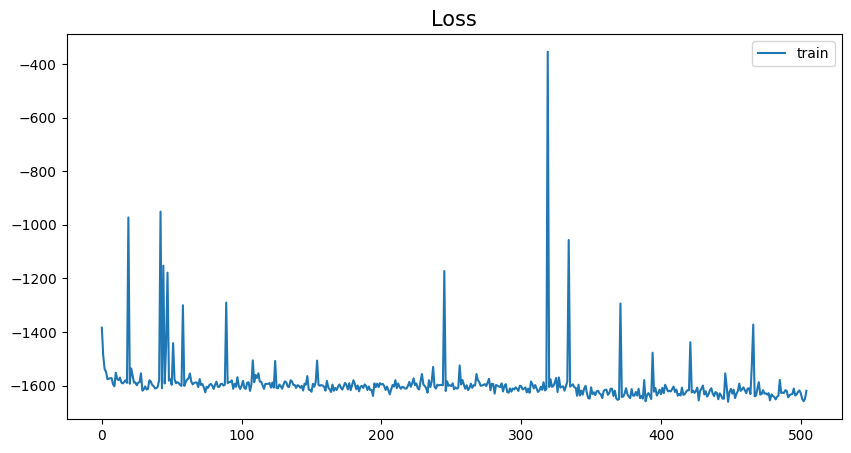

In [63]:
# view training
loss_history = np.array(loss_history).reshape(-1)
x = range(loss_history.shape[0])
plt.figure(figsize=(10,5))
plt.plot(x, loss_history, label='train')
plt.title('Loss', fontsize=15)
plt.legend(loc='upper right')
plt.show()

## Inference

At inference time, it's recommended to use the `generate()` method for autoregressive generation, similar to NLP models.

Forecasting involves getting data from the test instance sampler, which will sample the very last `context_length` sized window of values from each time series in the dataset, and pass it to the model. Note that we pass `future_time_features`, which are known ahead of time, to the decoder.

The model will autoregressively sample a certain number of values from the predicted distribution and pass them back to the decoder to return the prediction outputs:

In [64]:
model.eval()

forecasts_ = []

for batch in [next(iter(test_dataloader))]:
    outputs = model.generate(
        static_categorical_features=batch["static_categorical_features"].to(device)
        if config.num_static_categorical_features > 0
        else None,
        static_real_features=batch["static_real_features"].to(device)
        if config.num_static_real_features > 0
        else None,
        past_time_features=batch["past_time_features"].to(device),
        past_values=batch["past_values"].to(device),
        future_time_features=batch["future_time_features"].to(device),
        past_observed_mask=batch["past_observed_mask"].to(device),
    )
    forecasts_.append(outputs.sequences.cpu().numpy())

The model outputs a tensor of shape (`batch_size`, `number of samples`, `prediction length`, `input_size`). 

In this case, we get `100` possible values for the next `48` hours (for each example in the batch which is of size `64`):

In [65]:
forecasts_[0].shape

(1, 100, 48, 862)

We'll stack them vertically, to get forecasts for all time-series in the test dataset:

In [49]:
forecasts = np.vstack(forecasts_)
print(forecasts.shape)
# For all the data, the shape will be (100, 48, 862)

(1, 100, 48, 862)


We can evaluate the resulting forecast with respect to the ground truth out of sample values present in the test set. For that, we'll use the 🤗 [Evaluate](https://huggingface.co/docs/evaluate/index) library, which includes the [MASE](https://huggingface.co/spaces/evaluate-metric/mase) and [sMAPE](https://huggingface.co/spaces/evaluate-metric/smape) metrics.

We calculate both metrics for each time series in the dataset:

In [39]:
from evaluate import load
from gluonts.time_feature import get_seasonality

mase_metric = load("evaluate-metric/mase")
smape_metric = load("evaluate-metric/smape")

forecast_median = np.median(forecasts, 1)

mase_metrics = []
smape_metrics = []

for item_id, ts in enumerate(test_dataset):
    if item_id == 64:
        break
    training_data = ts["target"][:-prediction_length]
    ground_truth = ts["target"][-prediction_length:]
    mase = mase_metric.compute(
        predictions=forecast_median[item_id], 
        references=np.array(ground_truth), 
        training=np.array(training_data), 
        periodicity=get_seasonality(freq))
    mase_metrics.append(mase["mase"])
    
    smape = smape_metric.compute(
        predictions=forecast_median[item_id], 
        references=np.array(ground_truth), 
    )
    smape_metrics.append(smape["smape"])
    

ValueError: Mismatch in the number of predictions (48) and references (5)

In [ ]:
print(f"MASE: {np.mean(mase_metrics)}")

In [ ]:
print(f"sMAPE: {np.mean(smape_metrics)}")

To plot the prediction for any time series with respect the ground truth test data we define the following helper:

In [ ]:
import matplotlib.dates as mdates

def plot(ts_index):
    fig, ax = plt.subplots()

    index = pd.period_range(
        start=test_dataset[ts_index][FieldName.START],
        periods=len(test_dataset[ts_index][FieldName.TARGET]),
        freq=freq,
    ).to_timestamp()

    # Major ticks every half year, minor ticks every month,
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
    ax.xaxis.set_minor_locator(mdates.MonthLocator())

    ax.plot(
        index[-2*prediction_length:], 
        test_dataset[ts_index]["target"][-2*prediction_length:],
        label="actual",
    )

    plt.plot(
        index[-prediction_length:], 
        np.median(forecasts[ts_index], axis=0),
        label="median",
    )
    
    plt.fill_between(
        index[-prediction_length:],
        forecasts[ts_index].mean(0) - forecasts[ts_index].std(axis=0), 
        forecasts[ts_index].mean(0) + forecasts[ts_index].std(axis=0), 
        alpha=0.3, 
        interpolate=True,
        label="+/- 1-std",
    )
    plt.legend()
    plt.show()

For example:

In [ ]:
plot(2)

How do we compare against other models? The [Monash Time Series Repository](https://forecastingdata.org/#results) has a comparison table of test set MASE metrics which we can add to:

|Dataset | 	SES| 	Theta | 	TBATS| 	ETS	| (DHR-)ARIMA| 	PR|	CatBoost |	FFNN	| DeepAR | 	N-BEATS | 	WaveNet| 	**Transformer** (Our) |
|:------------------:|:-----------------:|:--:|:--:|:--:|:--:|:--:|:--:|:---:|:---:|:--:|:--:|:--:|
|Tourism Monthly | 	3.306 |	1.649 |	1.751 |	1.526|	1.589|	1.678	|1.699|	1.582	| 1.409	| 1.574|	1.482	|  **1.361**|

Note that, with our model, we are beating all other models reported (see also table 2 in the corresponding [paper](https://openreview.net/pdf?id=wEc1mgAjU-)), and we didn't do any hyperparameter tuning. We just trained the Transformer for 40 epochs. 

Of course, we need to be careful with just claiming state-of-the-art results on time series with neural networks, as it seems ["XGBoost is typically all you need"](https://www.sciencedirect.com/science/article/pii/S0169207021001679).  We are just very curious to see how far neural networks can bring us, and whether Transformers are going to be useful in this domain. This particular dataset seems to indicate that it's definitely worth exploring.

## Next Steps

We would encourage the readers to try out the [notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/time-series-transformers.ipynb) with other time series datasets from the [Hub](https://huggingface.co/datasets/monash_tsf) and replace the appropriate frequency and prediction length parameters. For your datasets, one would need to convert them to the convention used by GluonTS, which is explained nicely in their documentation [here](https://ts.gluon.ai/stable/tutorials/forecasting/extended_tutorial.html#What-is-in-a-dataset?). We have also prepared an example notebook showing you how to convert your dataset into the 🤗 datasets format [here](https://github.com/huggingface/notebooks/blob/main/examples/time_series_datasets.ipynb).

As time series researchers will know, there has been a lot of interest in applying Transformer based models to the time series problem. The vanilla Transformer is just one of many attention-based models and so there is a need to add more models to the library.

At the moment there is nothing stopping us from modeling multivariate time series, however for that one would need to instantiate the model with a multivariate distribution head. Currently, diagonal independent distributions are supported, and other multivariate distributions will be added. Stay tuned for a future blog post which will include a tutorial.

Another thing on the roadmap is time series classification. This entails adding a time series model with a classification head to the library, for the anomaly detection task for example. 

The current model assumes the presence of a date-time together with the time series values, which might not be the case for every time series in the wild. See for instance neuroscience datasets like the one from [WOODS](https://woods-benchmarks.github.io/). Thus, one would need to generalize the current model to make some inputs optional in the whole pipeline.

Finally, the NLP/Vision domain has benefitted tremendously from [large pre-trained models](https://arxiv.org/abs/1810.04805), while this is not the case as far as we are aware for the time series domain. Transformer based models seem like the obvious choice in pursuing this avenue of research and we cannot wait to see what researchers and practitioners come up with!
